In [2]:
# let's implement autograd from scratch using numpy
import numpy as np
from contextlib import contextmanager
from graphviz import Digraph

In [29]:
class Tensor:
    def __init__(self, array:np.ndarray, parents=None, op='') -> None:
        self.data = array
        self.parents = parents
        self.op = op
        self.p = None
    def __repr__(self) -> str:
        string = f"tensor({str(self.data)})"
        if self.op:
            string = string[:-1] +  ", " + self.op + ")"
        return  string
    def __add__(self, tensor : super):
        return Tensor(self.data + tensor.data, parents=(self, tensor), op='add')
    def __sub__(self, tensor: super):
        return Tensor(self.data - tensor.data, parents=(self, tensor), op='sub')
    def __mul__(self, tensor: super):
        return Tensor(self.data * tensor.data, parents=(self, tensor), op='mult')
    def __pow__(self, p):
        tensor = Tensor(self.data ** p, parents=(self,), op='pow')
        tensor.p = p
        return tensor
    def __matmul__(self, tensor: super):
        return Tensor(self.data @ tensor.data, parents=(self, tensor), op='matmul')
    def sum(self, axis=None, keepdims=False) -> super:
        return Tensor(np.sum(self.data, axis=axis, keepdims=keepdims), parents=(self,), op='sum')
    

    def backward(self, out_grads=None):
        if out_grads is None:
            out_grads = np.ones_like(self.data)
        # assert self.data.ndim == 1 and self.data.size() == 1, f"backward on scalars only, found {self.data.shape}"
        if self.parents is None:
            self.grad = Tensor(out_grads)
            return self.grad
        if self.op == "add":
            self.parents[0].backward(out_grads)
            self.parents[1].backward(out_grads)
        elif self.op == "sub":
            self.parents[0].backward(out_grads)
            self.parents[1].backward(-out_grads)
        elif self.op == "mult":
            self.parents[0].backward(self.parents[1].data * out_grads)
            self.parents[1].backward(self.parents[0].data * out_grads)
        elif self.op == "pow":
            p = self.p
            self.parents[0].backward(p * self.parents[0].data ** (p-1) * out_grads)
        elif self.op == "matmul":
            self.parents[0].backward(out_grads @ self.parents[1].data.T)
            self.parents[1].backward(self.parents[0].data.T @ out_grads)
        elif self.op == "sum":
            self.parents[0].backward(out_grads * np.ones_like(self.parents[0].data))
        



a = Tensor(np.ones(1))
b = Tensor(np.ones(1) + 1)
l = (a * b)**2

print(l)
l.backward()
print(a.grad, "- a grad should be 2 * (a * b) * b = 2 * 2 * 2 = 8")
print(b.grad, "- b grad should be 2 * (a * b) * a = 2 * 2 * 1 = 4")


tensor([4.], pow)
tensor([8.]) - a grad should be 2 * (a * b) * b = 2 * 2 * 2 = 8
tensor([4.]) - b grad should be 2 * (a * b) * a = 2 * 2 * 1 = 4


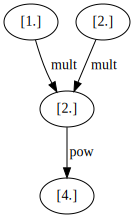

In [30]:
# visualize the graph
def visualize(tensor:Tensor):
    dot = Digraph()
    def add_node(tensor:Tensor):
        dot.node(str(id(tensor)), str(tensor.data))
        if tensor.parents is not None:
            for parent in tensor.parents:
                add_node(parent)
                dot.edge(str(id(parent)), str(id(tensor)), label=tensor.op)
    add_node(tensor)
    return dot

visualize(l)


tensor(7.478318028777463, sum)


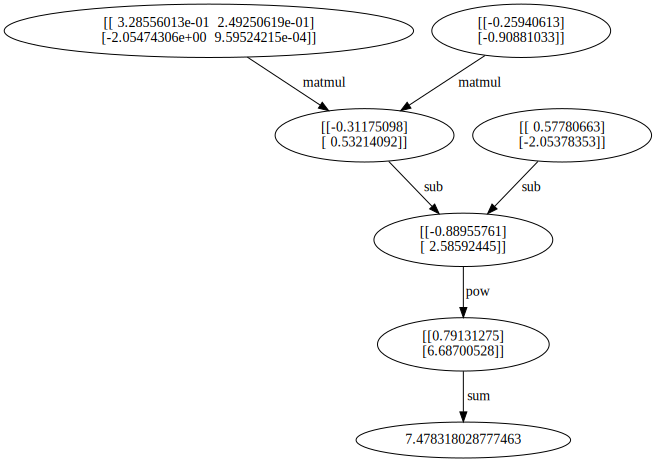

In [31]:
# 
W = Tensor(np.random.randn(2, 1))
X = Tensor(np.random.randn(2, 2))
y = Tensor(X.sum(axis=1, keepdims=True).data) # solution must [1, 1]
loss = ((X@W - y)**2).sum()
print(loss)
visualize(loss)

In [50]:
import tqdm
steps = 10000
pbar = tqdm.tqdm(range(steps))
for i in pbar:
    loss = ((X@W - y)**2).sum()
    loss.backward()
    W.data -= 0.01 * W.grad.data
    pbar.set_postfix({"loss": loss.data, "W": W.data.flatten().tolist()})

  3%|▎         | 322/10000 [00:00<00:05, 1663.92it/s, loss=3.54e-6, W=[1.0001427697419192, 0.9923734258595831]]

100%|██████████| 10000/10000 [00:05<00:00, 1901.31it/s, loss=2.34e-16, W=[1.0000000011609627, 0.9999999379828816]]
